# Reverse Music Recommendation <img align="right" width=15% src="https://cdn.freelogovectors.net/wp-content/uploads/2018/08/swisscom-logo.png">

## Table of Contents:
* [EDA + Pre-Processing](#eda)
* [Baseline: Nearest Neighbors](#baseline)
* [Matrix Factorization: Alternating Least Squares](#als)
* [Reverse Recommendation](#revrec)
* [Diversity](#diversity)
* [Conclusion](#conclusion)

In [1]:
# Execute this if using jupyter lab for tqdm to render properly (you'll also need node.js)
!jupyter nbextension enable --py widgetsnbextension

Config option `kernel_spec_manager_class` not recognized by `EnableNBExtensionApp`.
Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [2]:
import random

import implicit
import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import seaborn as sns
from implicit.als import AlternatingLeastSquares
from implicit.evaluation import mean_average_precision_at_k, train_test_split
from implicit.nearest_neighbours import CosineRecommender
from implicit.utils import nonzeros
from IPython.display import set_matplotlib_formats
from optuna import samplers
from pandas_profiling import ProfileReport
from scipy.sparse import coo_matrix
from sklearn.metrics.pairwise import cosine_similarity

from utils import recommend_users, save_als_model

%matplotlib inline
set_matplotlib_formats("svg")

In [3]:
RANDOM_SEED = 27
SAVE_DIR = "./models/"

## EDA + Pre-Processing <a class="anchor" id="eda"></a>

In [4]:
# importing data
tracks_df = pd.read_csv(
    "./data/userid-timestamp-artid-artname-traid-traname.tsv",
    sep="\t",
    usecols=[0, 4, 5],
    names=["userid", "traid", "traname"],
)
tracks_df.head()

userid traid                                     traname
0  user_000001   NaN  Fuck Me Im Famous (Pacha Ibiza)-09-28-2007
1  user_000001   NaN           Composition 0919 (Live_2009_4_15)
2  user_000001   NaN                        Mc2 (Live_2009_4_15)
3  user_000001   NaN                     Hibari (Live_2009_4_15)
4  user_000001   NaN                        Mc1 (Live_2009_4_15)

In [5]:
users_df = pd.read_csv("./data/userid-profile.csv")
users_df.head()

#id gender   age        country    registered
0  user_000001      m   NaN          Japan  Aug 13, 2006
1  user_000002      f   NaN           Peru  Feb 24, 2006
2  user_000003      m  22.0  United States  Oct 30, 2005
3  user_000004      f   NaN            NaN  Apr 26, 2006
4  user_000005      m   NaN       Bulgaria  Jun 29, 2006

In [6]:
# eda report generation
profile = ProfileReport(
    tracks_df,
    title="Tracks Profiling Report",
    minimal=False,
    html={"style": {"theme": "flatly"}},
)
profile.to_notebook_iframe()

Key learnings of this report:
- We have a high number of songs: ~960.000
- We're missing ~11% of the tracks' ids

In [7]:
users_profile = ProfileReport(
    users_df,
    title="Users Profiling Report",
    minimal=False,
    html={"style": {"theme": "flatly"}},
)
users_profile.to_notebook_iframe()

Key learnings:
   - Gender is imbalanced
   - age is missing too much (~71%) to be useful
   - The dataset is dominated by US and UK nationals

In [8]:
print(
    f'{100 * len(tracks_df[(tracks_df["traid"].isna()) & (~tracks_df["traname"].isna())]) / len(tracks_df):.2f}% of dataset will be lost to missing traid'
)

11.32% of dataset will be lost to missing traid


We could "rebuild" the misssing ids to help improve our model later

In [9]:
# dropping empty rows before creating the plays df
# aggregating the data to create a uerid, traid, plays df
plays_df = pd.DataFrame(
    tracks_df[["userid", "traid"]].dropna().groupby(["userid", "traid"]).size(),
    columns=["plays"],
).reset_index()
plays_df.head()

userid                                 traid  plays
0  user_000001  00237585-8e04-4cd5-a785-f2185492ab0b      2
1  user_000001  0024d72c-136f-49f2-9078-ce4b39b94d3f      4
2  user_000001  0025055f-39c3-43e2-b874-3bf42bbc9212      2
3  user_000001  002e254d-4624-49f4-b78a-b40711b9e4f3      3
4  user_000001  00b07689-ec4c-4773-94ce-06f3d198431e      4

In [10]:
plays_profile = ProfileReport(
    plays_df,
    title="Plays Profiling Report",
    minimal=False,
    html={"style": {"theme": "flatly"}},
)
plays_profile.to_notebook_iframe()

Key learnings from the report:
- Users/Songs are higly dominated with low play counts:
    - 42.2% for play==1
    - 16.2% for play==2
- A few users have an abnormaly high number of plays for a song (>2000 plays)

In [11]:
# let's checkout how many different different songs do users play
plays_df[["userid", "traid"]].drop_duplicates().groupby("userid").size().describe()

count      992.000000
mean      3989.724798
std       4670.861546
min          2.000000
25%       1158.250000
50%       2717.500000
75%       5134.250000
max      59255.000000
dtype: float64

That's surprinsigly high !

The dataset is quite large for our local machine, let's see if some songs have been rarely listened to (N plays through the entire dataset)

In [12]:
# computing how many plays do each song get
songs_plays_df = plays_df.groupby(["traid"]).sum().reset_index()
songs_plays_df.describe()

plays
count  960402.000000
mean       17.634424
std        65.460833
min         1.000000
25%         1.000000
50%         4.000000
75%        11.000000
max      3991.000000

In [13]:
songs_plays_df.head()

traid  plays
0  00000891-ca9c-490c-9fae-fff04957c9ef      4
1  00000baf-9215-483a-8900-93756eaf1cfc     13
2  000011ea-a75a-4b4a-9ab7-e8b3c6c64705      1
3  0000167c-95f5-48eb-b15f-04790e09a765     10
4  000067b7-dcad-4253-8a72-6db4bb029594      1

We'll choose some arbitrarly single digit number as a cutoff for the numer of times a song got played

In [14]:
N = 7
print(
    f'{100*len(songs_plays_df[songs_plays_df["plays"] < N]) / len(songs_plays_df):.2f}% of songs have been played less than {N} times'
)

64.40% of songs have been played less than 7 times


Since the number of users is quite small (~1000) we'll try to keep all of them but get rid of the "obscure" songs

In [15]:
obscure_songs = songs_plays_df[songs_plays_df["plays"] < N]["traid"]
plays_df = plays_df[~plays_df["traid"].isin(obscure_songs)]
plays_df = plays_df.copy()

In [16]:
print(f'{len(plays_df["traid"].drop_duplicates())} songs remaining')

341934 songs remaining


In [18]:
plays_df["userid"] = plays_df["userid"].astype("category")
plays_df["traid"] = plays_df["traid"].astype("category")

# create a sparse matrix of all the tracks/user/play triples
# The Matrix is actually transposed, meaning that we pass tracks instead of users to our model
plays = coo_matrix(
    (
        plays_df["plays"].astype(np.float64),
        (plays_df["userid"].cat.codes, plays_df["traid"].cat.codes),
    )
)

# random_state parameter implemented in https://github.com/benfred/implicit/pull/411
# but still not pushed to conda/pip
train_user_items, test_user_items = train_test_split(
    plays,
    train_percentage=0.8,
    # random_state=RANDOM_SEED,
)

In [19]:
matrix_size = (
    plays.shape[0] * plays.shape[1]
)  # Number of possible interactions in the matrix
num_purchases = len(plays.nonzero()[0])  # Number of items interacted with
sparsity = 100 * (1 - (num_purchases / matrix_size))
print(f"The matrix is {sparsity:.2f}% sparse")

The matrix is 99.09% sparse


## Baseline: Nearest Neighbors <a class="anchor" id="baseline"></a>
We'll fit and tune a basic item-item (in our case user-user) cosine recommender as a baseline

In [20]:
# rough optimization of the NN model
N_TRIALS = 20
K = 5


def optimize_nn(trial):
    neighbors = trial.suggest_int("K", 20, 100, 10)
    nn = CosineRecommender(K=neighbors)
    nn.fit(train_user_items)
    map_at_k = mean_average_precision_at_k(
        nn, train_user_items.T, test_user_items.T, K=K
    )
    return map_at_k


sampler = samplers.TPESampler(seed=RANDOM_SEED)
nn_study = optuna.create_study(
    direction="maximize", study_name="nearest_neighbors_study"
)
nn_study.optimize(optimize_nn, n_trials=N_TRIALS, n_jobs=1, show_progress_bar=True)

[I 2020-11-08 09:48:46,298] A new study created in memory with name: nearest_neighbors_study
/home/tariq/miniconda3/envs/reverse-rec/lib/python3.8/site-packages/optuna/progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()



[I 2020-11-08 09:48:52,210] Trial 0 finished with value: 0.06598998377207425 and parameters: {'K': 20}. Best is trial 0 with value: 0.06598998377207425.



[I 2020-11-08 09:48:58,779] Trial 1 finished with value: 0.06917890113660739 and parameters: {'K': 70}. Best is trial 1 with value: 0.06917890113660739.



[I 2020-11-08 09:49:05,578] Trial 2 finished with value: 0.06931979470015971 and parameters: {'K': 80}. Best is trial 2 with value: 0.06931979470015971.



[I 2020-11-08 09:49:12,001] Trial 3 finished with value: 0.06889633860398975 and parameters: {'K': 60}. Best is trial 2 with value: 0.06931979470015971.



[I 2020-11-08 09:49:18,891] Trial 4 finished with value: 0.06965367425771801 and parameters: {'K': 100}. Best is trial 4 with value: 0.06965367425771801.



[I 2020-11-08 09:49:25,869] Trial 5 finished with value: 0.06965367425771801 and parameters: {'K': 100}. Best is trial 4 with value: 0.06965367425771801.



[I 2020-11-08 09:49:32,619] Trial 6 finished with value: 0.06931979470015971 and parameters: {'K': 80}. Best is trial 4 with value: 0.06965367425771801.



[I 2020-11-08 09:49:38,672] Trial 7 finished with value: 0.06698157789995189 and parameters: {'K': 30}. Best is trial 4 with value: 0.06965367425771801.



[I 2020-11-08 09:49:44,867] Trial 8 finished with value: 0.06795458611342947 and parameters: {'K': 40}. Best is trial 4 with value: 0.06965367425771801.



[I 2020-11-08 09:49:51,679] Trial 9 finished with value: 0.06931979470015971 and parameters: {'K': 80}. Best is trial 4 with value: 0.06965367425771801.



[I 2020-11-08 09:49:58,694] Trial 10 finished with value: 0.06965367425771801 and parameters: {'K': 100}. Best is trial 4 with value: 0.06965367425771801.



[I 2020-11-08 09:50:05,836] Trial 11 finished with value: 0.06965367425771801 and parameters: {'K': 100}. Best is trial 4 with value: 0.06965367425771801.



[I 2020-11-08 09:50:12,737] Trial 12 finished with value: 0.06965367425771801 and parameters: {'K': 100}. Best is trial 4 with value: 0.06965367425771801.



[I 2020-11-08 09:50:19,626] Trial 13 finished with value: 0.06950117342938379 and parameters: {'K': 90}. Best is trial 4 with value: 0.06965367425771801.



[I 2020-11-08 09:50:25,952] Trial 14 finished with value: 0.06848916337716351 and parameters: {'K': 50}. Best is trial 4 with value: 0.06965367425771801.



[I 2020-11-08 09:50:32,769] Trial 15 finished with value: 0.06950117342938379 and parameters: {'K': 90}. Best is trial 4 with value: 0.06965367425771801.



[I 2020-11-08 09:50:39,585] Trial 16 finished with value: 0.06950117342938379 and parameters: {'K': 90}. Best is trial 4 with value: 0.06965367425771801.



[I 2020-11-08 09:50:46,099] Trial 17 finished with value: 0.06889633860398975 and parameters: {'K': 60}. Best is trial 4 with value: 0.06965367425771801.



[I 2020-11-08 09:50:53,115] Trial 18 finished with value: 0.06965367425771801 and parameters: {'K': 100}. Best is trial 4 with value: 0.06965367425771801.



[I 2020-11-08 09:50:59,800] Trial 19 finished with value: 0.06917890113660739 and parameters: {'K': 70}. Best is trial 4 with value: 0.06965367425771801.



In [21]:
print(f"MAP@5 for our best Cosine model: {nn_study.best_trial.value:.2f}")

MAP@5 for our best Cosine model: 0.07


## Matrix Factorization: Alternating Least Squares <a class="anchor" id="als"></a>

In [22]:
# Optimization of the ALS MF model
K = 5
# As this is quite computationally expensive we'll just run it for a few iterations
N_TRIALS = 20


def optimize_als(trial):
    """Runs multiple "trials" with various parameters to
    determine the best hyper parameters to use

    Args:
        trial (Trial): a Trial object which does not need to be instanciated
    """
    # matrix__confidence = trial.suggest_int("matrix__confidence", 2, 100, 5)
    factors = trial.suggest_int("factors", 30, 300, 10)
    regularization = trial.suggest_loguniform(
        "regularization", 1e-4, 1
    )  # cannot start at 0
    iterations = trial.suggest_int("iterations", 10, 100, 10)
    # alpha is a scaling factor for the raw ratings matrix https://github.com/benfred/implicit/issues/199
    alpha = trial.suggest_int("alpha", 1, 15, 1)
    als = AlternatingLeastSquares(
        factors=factors,
        regularization=regularization,
        iterations=iterations,
        random_state=RANDOM_SEED,
    )
    als.fit(alpha * train_user_items)
    map_at_k = mean_average_precision_at_k(
        als, alpha * train_user_items.T, alpha * test_user_items.T, K=K, num_threads=0
    )
    # as a safety measure let's save the models
    save_als_model(als_model=als, trial=trial, mapk=map_at_k, save_dir=SAVE_DIR)
    return map_at_k


study = optuna.create_study(direction="maximize", study_name="als_study")
study.optimize(optimize_als, n_trials=N_TRIALS, n_jobs=1, show_progress_bar=True)

[I 2020-11-08 09:50:59,824] A new study created in memory with name: als_study



[I 2020-11-08 10:16:37,664] Trial 0 finished with value: 0.11529669846623077 and parameters: {'factors': 120, 'regularization': 0.0013855034567313456, 'iterations': 100, 'alpha': 9}. Best is trial 0 with value: 0.11529669846623077.



[I 2020-11-08 10:26:10,187] Trial 1 finished with value: 0.09549635083050313 and parameters: {'factors': 120, 'regularization': 0.024395087991464542, 'iterations': 30, 'alpha': 15}. Best is trial 0 with value: 0.11529669846623077.



[I 2020-11-08 10:31:10,103] Trial 2 finished with value: 0.06104671804985206 and parameters: {'factors': 300, 'regularization': 0.00013689294132614318, 'iterations': 10, 'alpha': 14}. Best is trial 0 with value: 0.11529669846623077.



[I 2020-11-08 10:41:53,907] Trial 3 finished with value: 0.11793662211128268 and parameters: {'factors': 110, 'regularization': 0.0002411904079964364, 'iterations': 40, 'alpha': 2}. Best is trial 3 with value: 0.11793662211128268.



[I 2020-11-08 10:45:23,983] Trial 4 finished with value: 0.09839207757865893 and parameters: {'factors': 50, 'regularization': 0.12916598285148034, 'iterations': 10, 'alpha': 6}. Best is trial 3 with value: 0.11793662211128268.



[I 2020-11-08 10:56:37,381] Trial 5 finished with value: 0.11846354456120411 and parameters: {'factors': 90, 'regularization': 0.00036642870756740616, 'iterations': 60, 'alpha': 5}. Best is trial 5 with value: 0.11846354456120411.



[I 2020-11-08 11:02:16,520] Trial 6 finished with value: 0.08359780880458298 and parameters: {'factors': 150, 'regularization': 0.07897434052139005, 'iterations': 20, 'alpha': 14}. Best is trial 5 with value: 0.11846354456120411.



[I 2020-11-08 11:10:53,249] Trial 7 finished with value: 0.10299967607633052 and parameters: {'factors': 30, 'regularization': 0.22169649015725995, 'iterations': 80, 'alpha': 4}. Best is trial 5 with value: 0.11846354456120411.



[I 2020-11-08 11:25:25,715] Trial 8 finished with value: 0.09144575416522333 and parameters: {'factors': 270, 'regularization': 0.010385692091284341, 'iterations': 60, 'alpha': 13}. Best is trial 5 with value: 0.11846354456120411.



[I 2020-11-08 11:30:02,838] Trial 9 finished with value: 0.09237226054260303 and parameters: {'factors': 250, 'regularization': 0.06569372165445782, 'iterations': 10, 'alpha': 1}. Best is trial 5 with value: 0.11846354456120411.



[I 2020-11-08 11:42:24,146] Trial 10 finished with value: 0.10424383142419398 and parameters: {'factors': 210, 'regularization': 0.0013656298532361089, 'iterations': 60, 'alpha': 10}. Best is trial 5 with value: 0.11846354456120411.



[I 2020-11-08 11:49:18,440] Trial 11 finished with value: 0.11794146244126143 and parameters: {'factors': 90, 'regularization': 0.0001315465148875616, 'iterations': 40, 'alpha': 2}. Best is trial 5 with value: 0.11846354456120411.



[I 2020-11-08 11:57:20,416] Trial 12 finished with value: 0.11721004994352373 and parameters: {'factors': 70, 'regularization': 0.0005915654006266763, 'iterations': 50, 'alpha': 4}. Best is trial 5 with value: 0.11846354456120411.



[I 2020-11-08 12:08:51,361] Trial 13 finished with value: 0.11745817573811607 and parameters: {'factors': 80, 'regularization': 0.00011956800944633766, 'iterations': 80, 'alpha': 6}. Best is trial 5 with value: 0.11846354456120411.



[I 2020-11-08 12:22:30,375] Trial 14 finished with value: 0.11434144783293919 and parameters: {'factors': 180, 'regularization': 0.001955817246467882, 'iterations': 70, 'alpha': 2}. Best is trial 5 with value: 0.11846354456120411.



[I 2020-11-08 12:27:27,389] Trial 15 finished with value: 0.10164138394799328 and parameters: {'factors': 30, 'regularization': 0.00044461998695749635, 'iterations': 40, 'alpha': 4}. Best is trial 5 with value: 0.11846354456120411.



[I 2020-11-08 12:34:02,146] Trial 16 finished with value: 0.1137823976597032 and parameters: {'factors': 80, 'regularization': 0.004639858902406458, 'iterations': 40, 'alpha': 7}. Best is trial 5 with value: 0.11846354456120411.



[I 2020-11-08 12:55:32,215] Trial 17 finished with value: 0.11223886565318698 and parameters: {'factors': 150, 'regularization': 0.00010173523573493694, 'iterations': 90, 'alpha': 1}. Best is trial 5 with value: 0.11846354456120411.



[I 2020-11-08 13:06:51,229] Trial 18 finished with value: 0.11860845938304068 and parameters: {'factors': 100, 'regularization': 0.6226602507192595, 'iterations': 50, 'alpha': 3}. Best is trial 18 with value: 0.11860845938304068.



[I 2020-11-08 13:24:52,004] Trial 19 finished with value: 0.10470111028542245 and parameters: {'factors': 190, 'regularization': 0.016334401733831185, 'iterations': 70, 'alpha': 11}. Best is trial 18 with value: 0.11860845938304068.



In [23]:
print(f"MAP@5 of the best ALS Model: {study.best_value}:.2f")

MAP@5 of the best ALS Model: 0.11860845938304068:.2f


We managed to get a **~5%** improvement, it's not very impressive. Further tuning and using the more of the whole dataset could certainly help in that.

Let's fit now our best model on the whole matrix for our recommendations

In [24]:
best_params = study.best_params
# factors = best_params["factors"]
regularization = best_params["regularization"]
# iterations = best_params["iterations"]
alpha = best_params["alpha"]
als = AlternatingLeastSquares(
    factors=10,
    regularization=regularization,
    iterations=2,
    random_state=RANDOM_SEED,
)
als.fit(alpha * plays)

In [25]:
type(als)

implicit.als.AlternatingLeastSquares

## Reverse Recommendation <a class="anchor" id="revrec"></a>

In [26]:
print(
    f'Number of unique (traid, traname) pairs: {len(tracks_df[["traid", "traname"]].dropna().drop_duplicates())}'
)

Number of unique (traid, traname) pairs: 960613


In [27]:
print(
    f'Number of unique traname: {len(tracks_df[["traid", "traname"]].dropna()["traname"].dropna().drop_duplicates())}'
)

Number of unique traname: 693233


Unsurprinsigly, song names are not unique. We'll then refrain from recommending using songs names as that would be dangerous (But that would have been nicer to do).

In [28]:
# mapping the userid and traid to the userd index in thet ALS factors
usercode_userids = (
    pd.concat([plays_df["userid"], plays_df["userid"].cat.codes], axis=1)
    .drop_duplicates()
    .set_index(0)["userid"]
).to_dict()
# mapping the musicid to the music index in the ALS factors
traid_tracode = (
    pd.concat([plays_df["traid"], plays_df["traid"].cat.codes], axis=1)
    .drop_duplicates()
    .set_index("traid")[0]
).to_dict()

let's try now our recommendations with a randomly sampled song

In [29]:
sample_song = random.sample(list(traid_tracode), 1)[0]
sample_song

'c3059fe1-fbe2-47c8-bbc1-252fb21d6b6a'

In [30]:
plays.shape

(992, 341934)

In [31]:
recommendations = recommend_users(
    als_model=als,
    plays_matrix=alpha * plays.tocsr(),
    traid="00de4a37-1faf-49bb-a470-b8f1030e60ec",
    n=10,
    tracks_mapping=traid_tracode,
    users_mapping=usercode_userids,
).set_index("userid")

## Diversity <a class="anchor" id="diversity"></a>

As a rough measure of diversity let's see how similar are the user factors of the recommended users

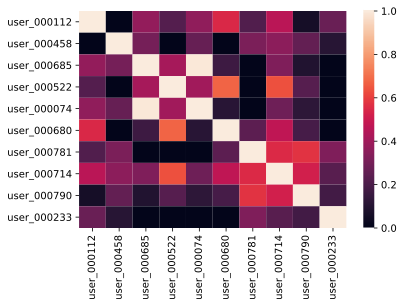

In [32]:
# Putting the recommended users' factors in a df to compute their pairwise cosine similarity
factors = pd.DataFrame(
    recommendations["factor"]
    .to_list(),
    index=recommendations.index,
)
factors.head()
similarity = cosine_similarity(factors)
_ = sns.heatmap(
    similarity,
    vmin=0,
    vmax=1,
    cmap=None,
    xticklabels=list(factors.index),
    yticklabels=list(factors.index),
)

Surprinsingly, the factors seem to be quite "dissimilar" (Apart from `user_000685` and `user_000074`). The factors should in theory be close to each others, as similar users should like similar songs. This could be due to poor performnce from the model.

In [33]:
recommended_users = [x for x in list(recommendations.index)]
recommended_users_df = users_df[users_df["#id"].isin(recommended_users)]
recommended_users_df

#id gender   age        country    registered
73   user_000074      m  35.0         Turkey   Jun 9, 2005
111  user_000112      f  30.0         Turkey  Mar 25, 2006
232  user_000233      m  25.0  United States  Jul 20, 2005
453  user_000458      f   NaN      Argentina   Feb 1, 2006
515  user_000522      f   NaN         Norway   Nov 9, 2005
672  user_000680    NaN   NaN            NaN  May 23, 2005
677  user_000685      m   NaN         Norway  Oct 13, 2004
706  user_000714      m   NaN       Colombia  Sep 23, 2006
773  user_000781      f   NaN  United States   Dec 4, 2005
782  user_000790      f   NaN            NaN   Feb 1, 2006

Sadly, we know from our EDA that 71.2% of users' age are missing, we won't gain much insights from there.
We have a 50/50 split on gender in our recommendation, which is interesting knowing that the user dataset is highly inbalanced in that regard.

Let's quickly explore the `usersha1-profile.csv` dataset to see if it is of better quality

In [34]:
full_users_df = pd.read_csv(
    "./data/usersha1-profile.csv",
    names=["usersha1", "gender", "age", "country", "sub-date"],
)
full_users_df.head()

usersha1 gender   age        country  \
0  00000c289a1829a808ac09c00daf10bc3c4e223b      f  22.0        Germany   
1  00001411dc427966b17297bf4d69e7e193135d89      f   NaN         Canada   
2  00004d2ac9316e22dc007ab2243d6fcb239e707d    NaN   NaN        Germany   
3  000063d3fe1cf2ba248b9e3c3f0334845a27a6bf      m  19.0         Mexico   
4  00007a47085b9aab8af55f52ec8846ac479ac4fe      m  28.0  United States   

       sub-date  
0   Feb 1, 2007  
1   Dec 4, 2007  
2   Sep 1, 2006  
3  Apr 28, 2008  
4  Jan 27, 2006

In [35]:
full_users_profile = ProfileReport(
    full_users_df,
    title="Full Users Profiling Report",
    minimal=False,
    html={"style": {"theme": "flatly"}},
)
full_users_profile.to_notebook_iframe()

Key insights:
- Way more users present in this dataset: 359347 vs 992
- Less missing values in age: "only" 20% vs more than 70%
- Same story for gender with "only" 10% missing values

Using this dataset (but it does not contain song plays, only artists) we could cluster the initial users using the following variables: `age`, `num_days_since_sub` and `gender` (we wouldn't include country to limit the number of categorical variables). Then we'd be able to check which clusters our recommended users belong and if they're all in the same or similar clusters or if they're more "diverse" than that.

## Conclusion <a class="anchor" id="conclusion"></a>

In the end, the performance of the tried models was poor. 
An alternative approach to this problem would be to use the users-artists dataset. Which holds far more users and less items, we could expect better performance out of it. 
Using that recommending users from songs would have to be through a "hack":
song --> artis[song] --> recommendations.
We'd also have orders of magnitudes more users in the `usersha1-profile.csv` dataset, which also has far less missing data, allowing for more interesting exploration of the recommended users